In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import torchvision, torch

In [2]:
dmerge = datasets.get_data("pc-rsna-nih")

Merge_Dataset num_samples=173479
└ PC_Dataset num_samples=91658 views=['PA'] data_aug=None
└ RSNA_Pneumonia_Dataset num_samples=14511 views=['PA'] data_aug=None
└ NIH_Dataset num_samples=67310 views=['PA'] data_aug=None



In [3]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [4]:
models = [xrv.models.DenseNet(weights="all").cuda(),
          xrv.models.DenseNet(weights="mimic_ch").cuda(),
          xrv.baseline_models.jfhealthcare.DenseNet().cuda()]

In [13]:
for_eval = [
            "Cardiomegaly",
            "Atelectasis",
            "Effusion",
            "Lung Opacity",
            #"Pneumothorax",
            ]

In [7]:
# target = "Effusion"

# dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
# dwhere[:10]

# dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
# dwhere[:10]

In [15]:
# model = models[1]
# print(model.pathologies)
# print(model)

In [11]:
# print(target)
# sample = dmerge[dwhere[50]]
# image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

In [10]:
# params = attribution.compute_attribution(image.cuda(), "latentshift", model, target, ret_params=True, ae=ae)


Cardiomegaly
[0.71049803] -75 75
[0.7490959] -75 75
[0.6040336] -75 75
Atelectasis
[0.5355964] -75 75
[0.7174041] -75 75
[0.5573208] -75 75
Effusion
[0.67795473] -75 75
[0.62226117] -75 75
[0.50906956] -75 75
Lung Opacity
[0.55370283] -75 75
[0.25873494] -75 75


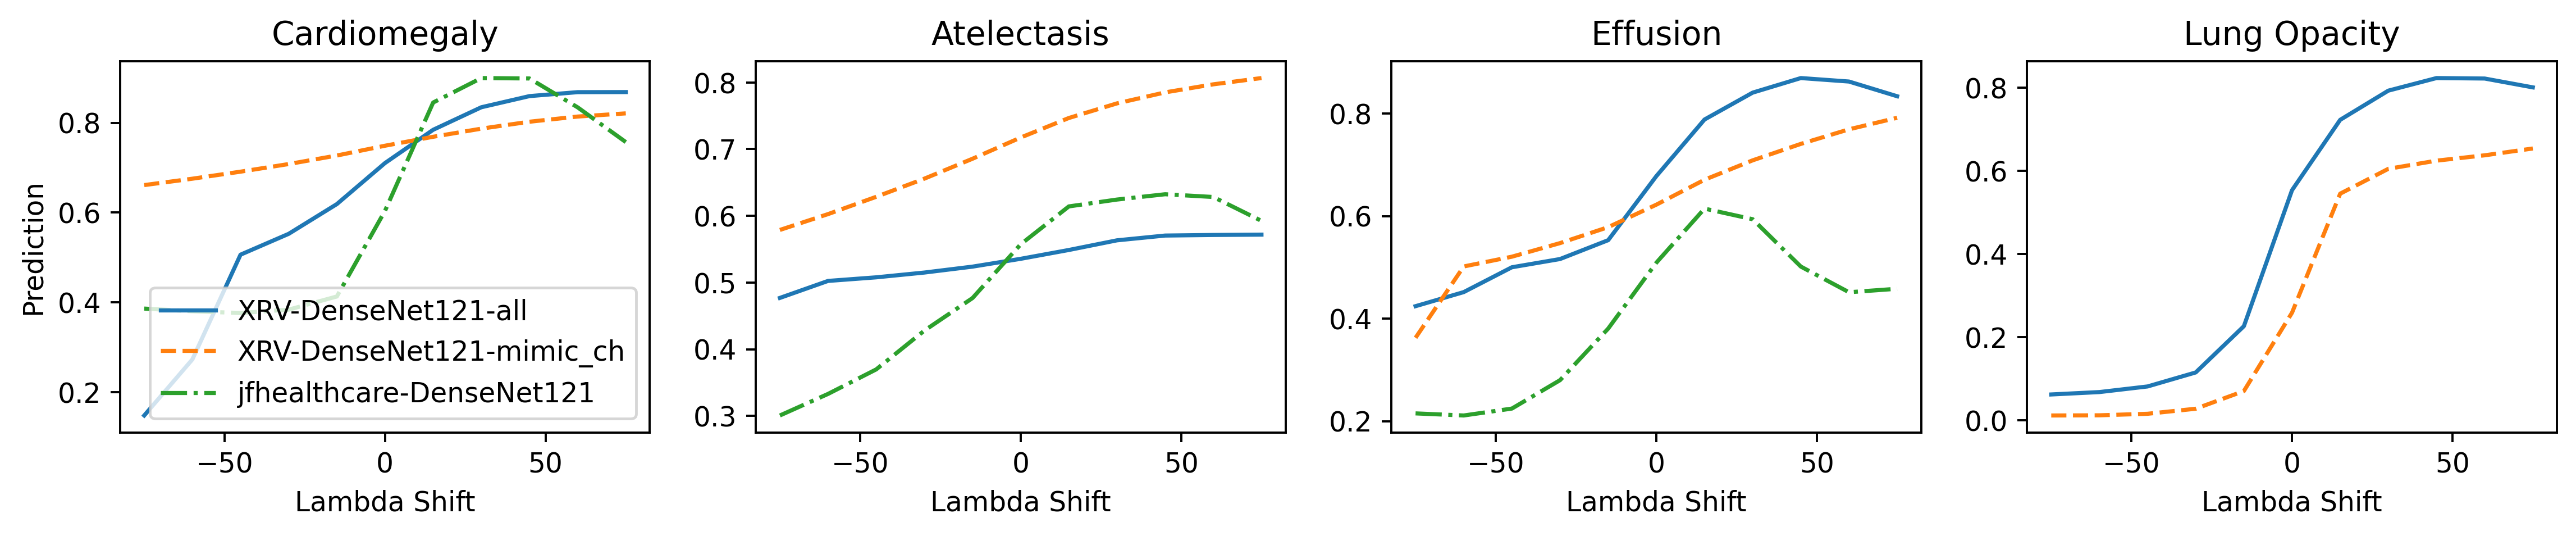

In [16]:
fig, ax = plt.subplots(1,len(for_eval), figsize=(16,2.5), dpi=350)
lines = ["-","--","-.",":"]
samples = [25,0,0,16]
for i, target in enumerate(for_eval):
    print(target)
    dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
    sample = dmerge[dwhere[samples[i]]]
    image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

    for j, model in enumerate(models):
        if target in model.pathologies:
            params = attribution.compute_attribution(image.cuda(), "latentshift", 
                                                     model, target, ae=ae,
                                                     ret_params=True, 
                                                    fixrange=[-75,75])
            ax[i].plot(params["lambdas"],params["y"], label=str(model), ls=lines[j])
    if i == 0:
        ax[i].set_ylabel("Prediction");
        ax[i].legend()
    ax[i].set_xlabel("Lambda Shift");
    ax[i].set_title(target);
